## MNIST Multiclass Kernel Perceptrons
IDs: <> and <>

In [57]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

#### Kernel Perceptron Class

In [72]:
class MultiClassKernelPerceptron():
    """
    A multiclass implementation of the kernel perceptron
    Designed for the MNIST dataset to classify digits 0-9
    """
        
    def __init__(self, kernel, num_digits=10):
        """
        Instantiates the perceptron instance

        Args:
            kernel: kernel function to use
            num_digits: optional param- number of digits to classify,
                assumes digits range from 0...num_digits
        """
        self.kernel = kernel
        self.num_classes = num_digits

    def train(self, X, Y, kernel_matrix=None):   
        """
        Trains the perceptron

        Args:
            X: training data (n x d)
            Y: training labels (n x 1)
            kernel_matrix: optional pre-calculated kernel matrix
        """
        max_epochs = 50
        self.X_training = X
        Y = Y.astype(int)

        # Calculate gram matrix if necessary
        if kernel_matrix is not None:
            self.gram_matrix = kernel_matrix
        else: 
            self.gram_matrix = self.get_kernel_matrix(self.kernel, X)

        self.alpha = self.update_alpha(self.gram_matrix, Y, self.num_classes, max_epochs)
    
    # Pulling this into a separate function for numba,
    #   but consider this as if it were appended to the train method
    @jit(nopython=True)
    def update_alpha(gram_matrix, Y, num_classes, max_epochs):
        
        num_data = gram_matrix.shape[0]
        alpha = np.zeros((num_data, num_classes))

        # Instantiate once and reuse in update step
        label_vector = -1 * np.ones(num_classes)
        zeros = np.zeros(num_classes)
        
        for epoch in range(max_epochs):
            for i in range(num_data):
                # Get decisions for all the classifiers
                decisions = np.sign(np.dot(alpha.T, gram_matrix[:, i]))

                # The label vector should be -1 for every index
                # except the one corresponding to the current Yi label
                label_vector[Y[i]] = 1

                # For a given classifier, if the decision * label <= 0,
                # the update is the label, otherwise it is zero
                update = np.where(decisions*label_vector <=0, label_vector, zeros)

                # Add the update to alpha, reset label vector
                alpha[i,:] += update
                label_vector[Y[i]] = -1
        
        return alpha
                
    def predict(self, X, kernel_matrix=None):
        """
        Predicts the labels of a new set of data

        Args:
            X: data to classify
            kernel_matrix: an optional parameter for a precalculated kernel
                between X and the training data
        """
        # If we need to compute a kernel matrix, we only need to find distances
        #   where the alphas are not 0.
        if kernel_matrix is None:
            relevant_indices = np.where(np.sum(self.alpha != 0, axis=1) > 0)[0]
            kernel_matrix = self.get_kernel_matrix(self.kernel, X, self.X_training[relevant_indices])
            alpha = self.alpha[relevant_indices]
        else: 
            # In this case, we don't know what the indices are anymore, 
            #   so we can't use the previous trick
            alpha = self.alpha

        # See how confident each classifier is that a given point is in that class
        #   i.e. the distance between the point and the decision boundary
        # We want to get a N x K matrix where N = number of classifiers, K = num data in X
        # Each value is given by the dot product of the alphas for the classifier
        #   and the distances from the data point to the training examples
        data_confidence_by_classifier = kernel_matrix @ alpha
        
        # Pick the label of the classifier with the max confidence
        # Each classifier operates on a 1-v-All basis
        predictions = np.argmax(data_confidence_by_classifier, axis=1)
        return predictions
    
    @staticmethod
    @jit(nopython=True)
    def get_kernel_matrix(kernel_func, X1, X2=None):
        """
        Calculates the full kernel matrix between X1 and X2
        using an input kernel function

        Args:
            kernel_func: kernel function
            X1: Ax1 vector
            X2: optional Bx1 vector
        Returns:
            (AxB) matrix of kernel distances if X2 is given
            (AxA) matrix otherwise
        """
        A = X1.shape[0]
        if X2 is None:
            # In one-matrix case, we can use symmetry
            kernel_matrix = np.empty((A,A), dtype=np.float32)
            for i in range(A):
                for j in range(i,A):
                    kernel_matrix[i, j] = kernel_func(X1[i], X1[j])
                    kernel_matrix[j, i] = kernel_matrix[i, j]
        else:
            B = X2.shape[0]
            kernel_matrix = np.empty((A,B), dtype=np.float32)
            for i in range(A):
                for j in range(B):
                    kernel_matrix[i, j] = kernel_func(X1[i], X2[j])
        return kernel_matrix

#### Helper Functions

In [59]:
def split_data(data, split_fraction):
    """
    Splits the data into two sets with the specified fraction.

    Args:
        data: numpy matrix of data
        split_fraction: fraction to split
    Returns:
        larger dataset, smaller dataset, shuffled indices, and split index
    """
    num_data = data.shape[0]
    indices = np.arange(num_data)
    np.random.shuffle(indices)
    shuffled_data = data[indices]

    split_index = int(num_data * split_fraction)
    return shuffled_data[:split_index], shuffled_data[split_index:], indices, split_index

def get_cross_validation_indices(data, num_folds):
    """
    Gets the indices of the data that represent a cross-validation split

    Args:
        data: numpy matrix of data
        num_folds: number of folds
    Returns:
        list of (start, end) tuples
    """
    num_data = data.shape[0]
    data_per_fold = int(num_data / num_folds)

    start = 0
    index_tuples = []
    for _ in range(num_folds):
        index_tuples.append((start, start + data_per_fold))
        start += data_per_fold
    
    index_tuples.append((start, num_data))
    return index_tuples

def get_data_and_labels(data):
    """
    Splits the data from the labels

    Args:
        data: numpy matrix of data
    Returns:
        data, labels
    """
    return data[:,1:], data[:,0]

def calculate_accuracy(predictions, actual):
    """
    Returns predicted accuracy

    Args:
        predictions: numpy array of predictions
        actual: actual values
    Returns:
        accuracy float
    """
    num_correct = np.sum(predictions == actual)
    return num_correct / actual.shape[0]

def get_polynomial_kernel(degree):
    """
    Returns a polynomial kernel with specified degree

    Args:
        degree: degree of polynomial
    Returns:
        polynomial kernel function
    """
    @jit(nopython=True)
    def polynomial_kernel(x1, x2):
        return (np.dot(x1, x2)) ** degree
    
    return polynomial_kernel

def split_kernels(kernel, split_index):
    """
    Returns a training and test kernel from an index to split

    Args:
        kernel: NxN gram matrix
        split_index: index < N, number of training examples
    Returns:
        training kernel matrix (square), test kernel matrix (rectangle)
    """
    # Grab the first split_index elements for the square training kernel
    #   and one of the remaining rectangles for the test kernel 
    training = kernel[:split_index,:split_index]
    test = kernel[split_index:,:split_index]
    return training, test

def get_training_validation_kernels(kernel, start, end):
    """
    Returns a training and validation kernel from cross-validation indices
    The start-end defines the validation region

    Args:
        kernel: NxN gram matrix
        start, end: indices < N of the validation region
    Returns:
        training kernel matrix (square), validation kernel matrix (rectangle)
    """
    # Build training array by picturing four corners of a square
    left = np.vstack((kernel[:start,:start], kernel[end:,:start]))
    right = np.vstack((kernel[:start,end:], kernel[end:,end:]))
    training = np.hstack((left, right))

    # Build validation array by picturing a rectangle
    valid = np.hstack((kernel[start:end, :start], kernel[start:end, end:]))
    return training, valid

#### Question 1: Basic Results

In [47]:
# Load data into numpy
data = np.genfromtxt('./zipcombo.dat')

# Define polynomial perceptrons, pre-calculate kernels
poly_perceptrons = [MultiClassKernelPerceptron(get_polynomial_kernel(d+1)) for d in range(7)]
poly_kernels = [p.get_kernel_matrix(p.kernel, data) for p in poly_perceptrons]

In [73]:
def run_20_iters(perceptrons, kernels):
    """
    Follows the instructions in Q1 of the coursework: 
        Reports the best accuracy of the perceptrons over 20 iterations

    Args:
        perceptrons: perceptrons to use
        kernels: pre-calculated kernels corresponding to the perceptrons
    Returns:
        accuracy stats for the 20 runs for each perceptron
    """
        
    stats = [[] for _ in range(len(perceptrons))]
    for iter in range(20):
        print("Currently running iter", iter)
        training, test, shuffle_indices, split_index = split_data(data, 0.8)
        train_X, train_Y = get_data_and_labels(training)
        test_X, test_Y = get_data_and_labels(test)

        for i, perceptron in enumerate(perceptrons):
            print("> Perceptron", i)
            shuffled_kernel = kernels[i][shuffle_indices, :][:, shuffle_indices]
            training_kernel, test_kernel = split_kernels(shuffled_kernel, split_index)

            perceptron.train(train_X, train_Y, training_kernel)
            predictions = perceptron.predict(test_X, test_kernel)
            accuracy = calculate_accuracy(predictions, test_Y)
            stats[i].append(accuracy)
    
    return stats

q1_stats = run_20_iters(poly_perceptrons, poly_kernels)

Currently running iter 0
> Perceptron 0
> Perceptron 1
> Perceptron 2
> Perceptron 3
> Perceptron 4
> Perceptron 5
> Perceptron 6
Currently running iter 1
> Perceptron 0
> Perceptron 1
> Perceptron 2
> Perceptron 3
> Perceptron 4
> Perceptron 5
> Perceptron 6
Currently running iter 2
> Perceptron 0


KeyboardInterrupt: 

In [76]:
# Summary statistics!
q1_summary = [[np.mean(runs)-np.std(runs),
               np.mean(runs)+np.std(runs)] 
    for runs in q1_stats]

print("Test accuracy by kernel degree")
for stat in q1_summary:
    print("{:.4f}".format(stat[0]),"{:.4f}".format(stat[1]))

Test accuracy by kernel degree
0.9022 0.9258
0.9667 0.9774
0.9672 0.9812
0.9683 0.9796
0.9677 0.9790
0.9704 0.9704
0.9629 0.9629


#### Question 2: Cross validation

In [78]:
def run_cv_20_iters(perceptrons, kernels):
    accuracy_stats = []
    best_degrees = []

    for iter in range(20):
        print("Currently running iter", iter)
        training, test, shuffle_indices, split_index = split_data(data, 0.8)
        test_X, test_Y = get_data_and_labels(test)
        full_train_X, full_train_Y = get_data_and_labels(training)

        # Cross-Validation step
        num_folds = 5
        cv_indices = get_cross_validation_indices(training, num_folds)

        # Pre-calculate kernel matrices
        shuffled_kernels = [split_kernels(k[shuffle_indices, :][:, shuffle_indices], split_index) for k in kernels]
        cv_accuracies = [[] for _ in perceptrons]
        
        # Iterate through CV sets
        for cur_idx in cv_indices:
            print("> Cross-validation", cur_idx)
            start, end = cur_idx
            cur_valid = training[start:end,:]
            cur_train = np.concatenate((training[:start,:], training[end:,:]))

            train_X, train_Y = get_data_and_labels(cur_train)
            valid_X, valid_Y = get_data_and_labels(cur_valid)

            # For each set, evaluate each perceptron
            for i, perceptron in enumerate(perceptrons):
                print(">> Perceptron", i)
                # Grab the training kernel of the i'th shuffled kernel
                full_training_kernel = shuffled_kernels[i][0]
                training_kernel, validation_kernel = get_training_validation_kernels(full_training_kernel, start, end)
                perceptron.train(train_X, train_Y, training_kernel)
                predictions = perceptron.predict(valid_X, validation_kernel)

                accuracy = calculate_accuracy(predictions, valid_Y)
                cv_accuracies[i].append(accuracy)
        
        # Choose the best perceptron, use it to train the whole set
        best_perceptron = np.argmax(np.mean(cv_accuracies, axis=1))
        best_degrees.append(best_perceptron + 1)

        # Leverage pre-computed kernel matrix
        training_kernel, test_kernel = shuffled_kernels[best_perceptron]

        chosen_perceptron = perceptrons[best_perceptron]
        chosen_perceptron.train(full_train_X,full_train_Y,training_kernel)
        test_predictions = chosen_perceptron.predict(test_X, test_kernel)
        test_accuracy = calculate_accuracy(test_predictions, test_Y)
        accuracy_stats.append(test_accuracy)

q2_stats, q2_ds = run_cv_20_iters(poly_perceptrons, poly_kernels)


Currently running iter 0
> Cross-validation (0, 1487)
>> Perceptron 0
>> Perceptron 1
>> Perceptron 2
> Cross-validation (1487, 2974)
>> Perceptron 0
>> Perceptron 1
>> Perceptron 2
> Cross-validation (2974, 4461)
>> Perceptron 0
>> Perceptron 1
>> Perceptron 2
> Cross-validation (4461, 5948)
>> Perceptron 0
>> Perceptron 1
>> Perceptron 2
> Cross-validation (5948, 7435)
>> Perceptron 0
>> Perceptron 1
>> Perceptron 2
> Cross-validation (7435, 7438)
>> Perceptron 0
>> Perceptron 1
>> Perceptron 2
Currently running iter 1
> Cross-validation (0, 1487)
>> Perceptron 0


KeyboardInterrupt: 

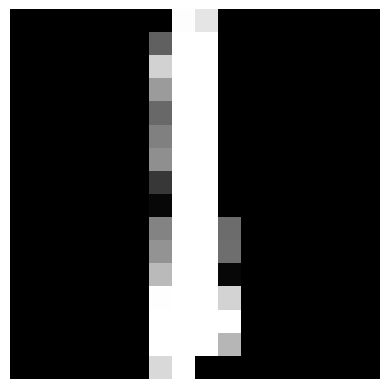

In [ ]:
def visualize_params(params):
    plt.figure()
    plt.imshow(np.reshape(params, (16,16)),
                interpolation="None",
                cmap='gray',
                vmin=0, 
                vmax=1)
    plt.axis('off')
    plt.show()

visualize_params(data[6,1:])


In [ ]:
data1 = np.genfromtxt('./zipcombo.dat')


In [ ]:
data1.shape
np.unique(data1[:,0])

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])